In [1]:
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import rand, tpe
from hyperopt import Trials
from hyperopt import fmin

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import DistanceMetric
from math import sqrt

In [2]:
url="https://raw.githubusercontent.com/S-Mann/hyperparameter_optimization/master/dataset/dataset.csv"
s=requests.get(url).content
dataset=pd.read_csv(io.StringIO(s.decode('utf-8')))

excluded_columns = [x not in ['model', 'msrp', 'model_year', 'popularity', 'profit_per_unit', 'units_sold','cost_per_unit'] for x in dataset.columns]

X = dataset.iloc[:,excluded_columns].values
y = dataset.iloc[:,dataset.columns == 'msrp'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=123)

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)
X_train = imp.transform(X_train)
imp = imp.fit(X_test)
X_test = imp.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
def knn_obj_func(hyperparams):    
    classifier = KNeighborsClassifier(n_neighbors=int(hyperparams[1]), metric=hyperparams[0])
    classifier.fit(X_train, np.ravel(y_train, order='C'))
    
    y_pred = classifier.predict(X_test)
    
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    return rmse

In [4]:
metric_types = ['minkowski','euclidean', 'manhattan', 'chebyshev', 'canberra', 'braycurtis']
# This is a random k value and its RMSE
random_hyperparam = [metric_types[0], 3]
random_loss = knn_obj_func(random_hyperparam)
random_loss

13522.133991548919

In [5]:
space = hp.choice('a',
    [
        (metric_types[0], hp.uniform('c1', 2, 100)),
        (metric_types[1], hp.uniform('c2', 2, 100)),
        (metric_types[2], hp.uniform('c3', 2, 100)),
        (metric_types[3], hp.uniform('c4', 2, 100)),
        (metric_types[4], hp.uniform('c5', 2, 100)),
        (metric_types[5], hp.uniform('c6', 2, 100))
    ])
samples = []

for _ in range(5000):
    samples.append(sample(space))

In [6]:
# Create objects for the algorithms
tpe_algo = tpe.suggest # Tree Structure Parzen Estimator
rand_algo = rand.suggest # Random Forest

# Create two trials objects to record your estimations
tpe_trials = Trials()
rand_trials = Trials()

In [7]:
# Run 2000 trials with the tpe algorithm with our objective function and domain space
tpe_best = fmin(fn=knn_obj_func, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=200, rstate= np.random.RandomState(50))

# Run 2000 trials with the random algorithm with our objective function and domain space
rand_best = fmin(fn=knn_obj_func, space=space, algo=rand_algo, trials=rand_trials, max_evals=200, rstate= np.random.RandomState(50))

100%|██████████| 200/200 [03:27<00:00,  1.31it/s, best loss: 7435.8209888702595]


Text(0.5, 1.0, 'Trails Vs Error for each approach')

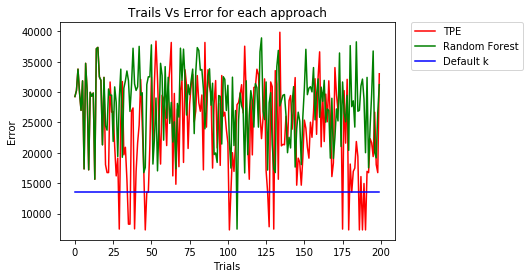

In [63]:
plt.plot(tpe_trials.losses(),color='red',label="TPE")
plt.plot(rand_trials.losses(),color='green',label="Random Forest")
plt.plot([random_loss for x in range(1,201)],color='blue',label="Default k")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Trials")
plt.ylabel("Error")
plt.title("Trails Vs Error for each approach")

In [58]:
print("Best distance measure for TPE is '{0}' with K value as {1}".format(metric_types[tpe_best['a']],int(tpe_best['c1'])))

Best distance measure for TPE is 'minkowski' with K value as 2


In [59]:
print("Best distance measure for Random Forest is '{0}' with K value as {1}".format(metric_types[rand_best['a']],int(rand_best['c6'])))

Best distance measure for Random Forest is 'braycurtis' with K value as 2
